# PySpark Logistic Regression Summary

Our full dataset file has around 9 million samples. When trying to run feature_generator, sklearn would error out since it was trying to keep all samples in memory.

For that, I started using pyspark to run our models.

All models were executed through notebooks in the *pyspark* folders. Each notebook in *pyspark* execute the same model but with a different sample size.

## Model

* Logistic Regression
* class_weight = 'balanced'

## Machine Specs:
* 2018 Mac Mini - 6 core

Docker Configuration:
* 9 CPUs
* 24 GB Ram
* 3 GB swap

Pyspark notebooks are executed via Docker images where Pyspark is installed

## Executing Docker container

```bash
cd ../pyspark
docker-compose up
docker ps # get the docker container ID
docker logs <container id> # get URL/token for jupyter notebook
```

Docker image will automatically rum jupyter lab. Once jupyter lab is up. Hit the following URL to access notebooks in the browser. It should look something like this


```
http://localhost:8888/lab?token=slfjaADFLJAhh
```

# Conclusion

With Logistic Regression, performance of our model did improve quickly up to a point. Once we reach over 2 million samples, there is a plateau where increasing sample size yielded minimal improvement to our model but training time increases drastically




In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import json

import util.report_util as ru
import util.plot_util as pu

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.WARN)
sns.set(font_scale=2)
%matplotlib inline

DEBUG = False

REPORT_DIR = "../reports"
REPORT_FILE = "201911-pyspark-report.csv"


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vinceluk/anaconda3/envs/

In [2]:
report = pd.read_csv(f'{REPORT_DIR}/{REPORT_FILE}', quotechar="'")

# flatten out classification report so we can graph later
report = ru.convert_dnn_report_format(report)

In [3]:
report["eval_metric"] = report.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))

# Model score stops improving after 2 million samples

* Minimal improvement in overall score after 200k samples
* Slopt of training time looks linear between 50k to 200k. Slope increases between 200k to 400k and another increase in slop after 400k samples

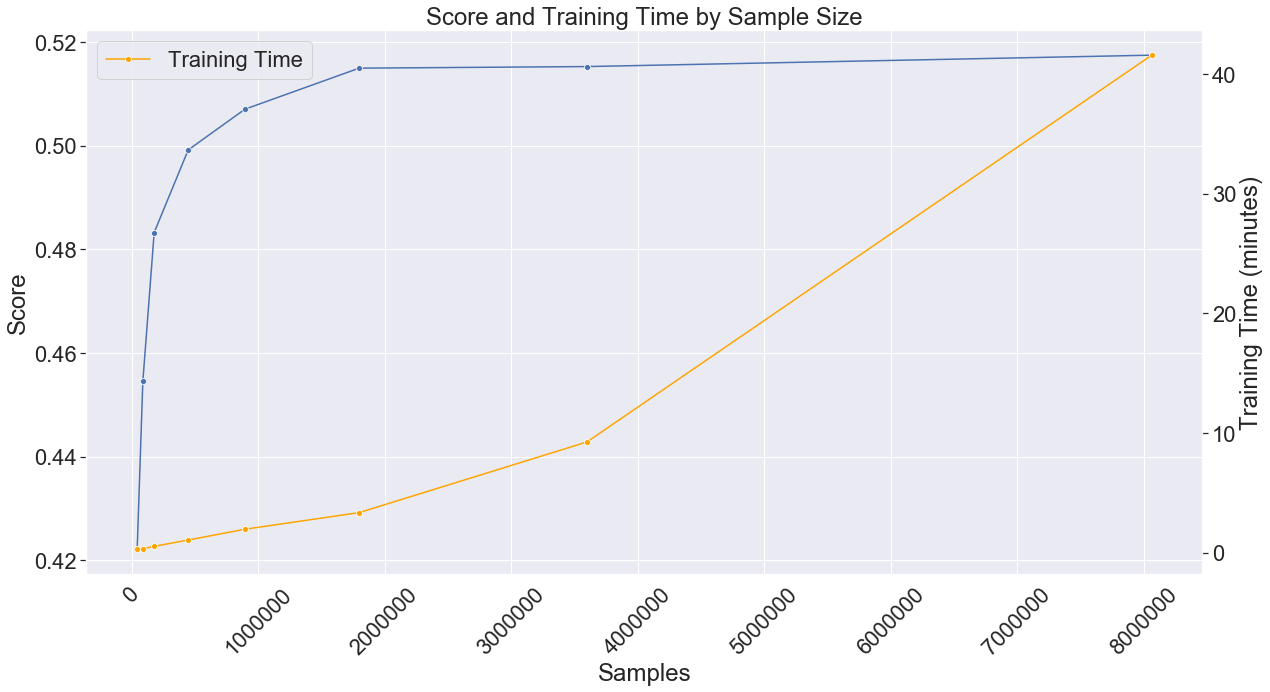

In [10]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=report, x="train_examples", y="eval_metric", sort=False, marker="o")
_ = plt.xticks(rotation=45)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Score")


a2 = a.twinx()
_ = sns.lineplot(data = report, x = "train_examples", y = "train_time_min", 
                 marker = "o",
                 sort = False, ax=a2, label="Training Time", color="orange")
_ = plt.ylabel("Training Time (minutes)")
a2.grid(False)

_ = plt.title("Score and Training Time by Sample Size")





In [5]:
report[["train_examples", "eval_metric", "train_time_min"]]

,train_examples,eval_metric,train_time_min
0,44726.0,0.422127,0.27
1,89544.0,0.454550,0.32
2,179168.0,0.483252,0.52
3,447989.0,0.499181,1.05
4,896004.0,0.507036,1.95
5,1799736.0,0.514962,3.34
6,3599433.0,0.515266,9.24
7,8064337.0,0.517467,41.56


# Visualizing Improvement vs Training Time

We will visualize gain from our model performance compared to training time

We will use a ratio between improvment of our score / increase in training time as we increase our sample size

As you can see, from 500k and beyond the rate of training time increase much faster than improvement in our model - meaning we need to spend more and more time training with less gain in our performance beyond this poing.

,train_examples,improvement_ratio
0,44726.0,NaN
1,89544.0,0.648472
2,179168.0,0.143506
3,447989.0,0.030057
4,896004.0,0.008728
5,1799736.0,0.005702
6,3599433.0,0.000052
7,8064337.0,0.000068


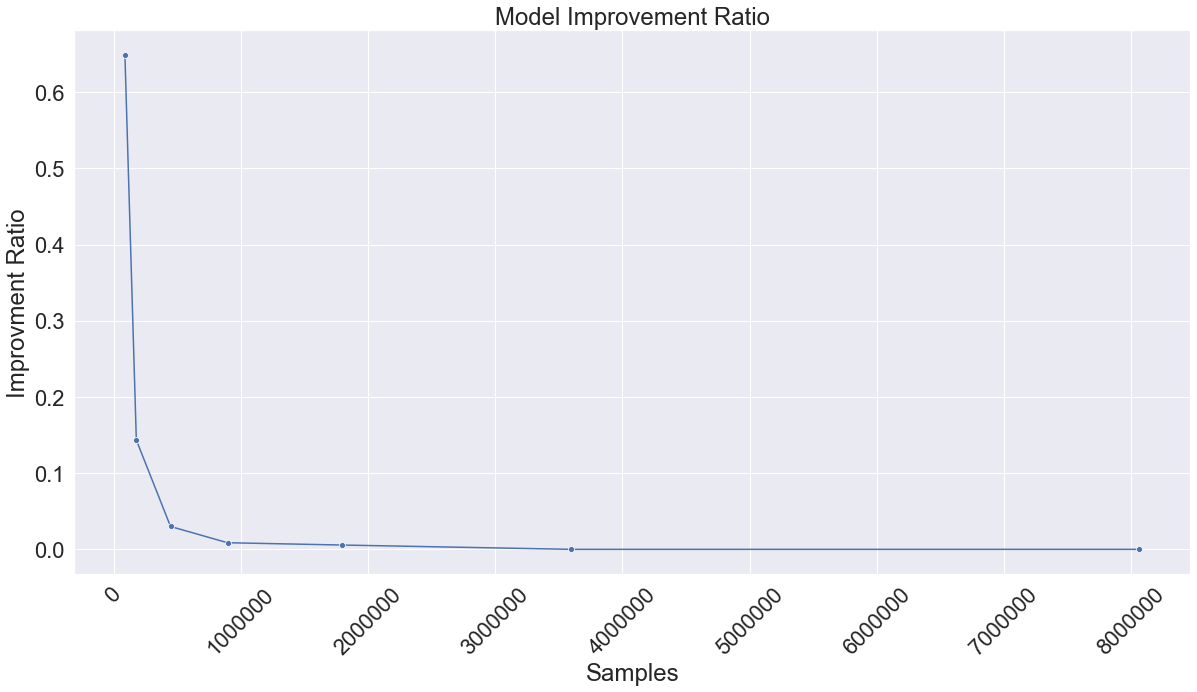

In [12]:
report.loc[0, "improvment_ratio"] = 0
report.loc[0, "eval_metric_diff"] = 0
report.loc[0, "train_time_min_diff"] = 0

for i in range(1, len(report)):
    report.loc[i, "eval_metric_diff"] = report.loc[i, "eval_metric"] - report.loc[i - 1, "eval_metric"]
    report.loc[i, "train_time_min_diff"] = report.loc[i, "train_time_min"] - report.loc[i - 1, "train_time_min"]
    report.loc[i, "improvement_ratio"] = report.loc[i, "eval_metric_diff"] / report.loc[i, "train_time_min_diff"]

f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=report, x="train_examples", y="improvement_ratio", sort=False, marker="o")
_ = plt.title("Model Improvement Ratio")
_ = plt.xticks(rotation=45)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Improvment Ratio")


report[["train_examples", "improvement_ratio"]]

# Classification Report Histogram

* Recall
    * 1-star recall improves until 400k but doesn't change much after
    * 2-star increases until around 2 million samples but doesn't change much after that
    * 3-star rating improved until around 400k samples
    * 4-star improves between 50k to 100k but minimal changes after
    * 5-star 
* Precision
    * 1-star precision improves until 200k samples but minimal changes after
    * 2-star precision increases slightly until around 900k samples
    * 3-star precision stays around the same after 1 million samples
    * 4-star precision stays around the same from 400k samples on
    * 5-star precision is around the same for all sample sizes


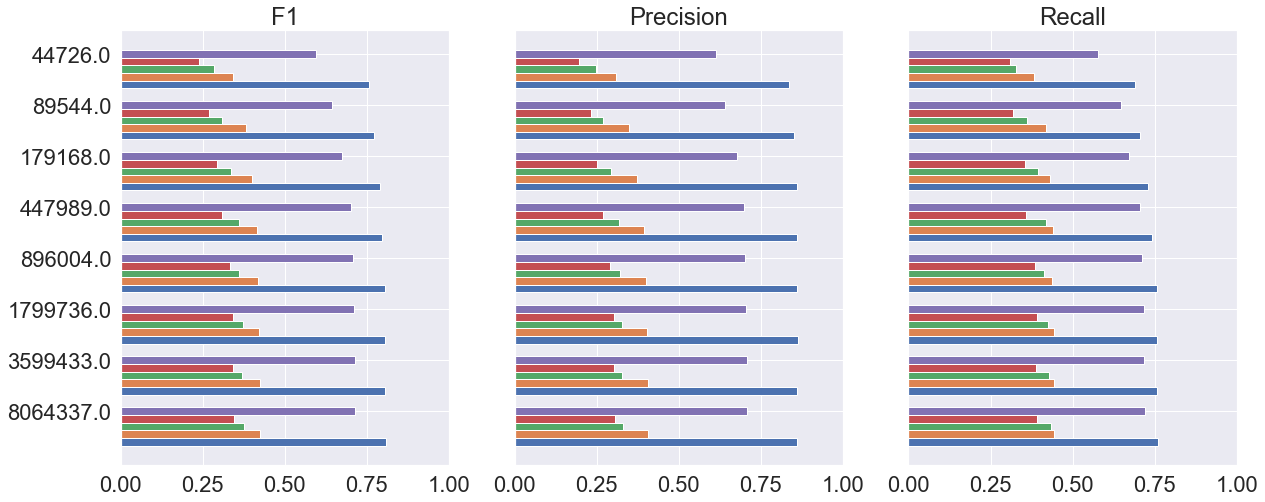

In [7]:
pu.plot_score_histograms(report, version=2, label="train_examples", sort=False)